# Evaluación de modelos

## Ejecución

En principio solo modificar la variable `model_name` con el nombre del modelo que generó los resultados, y las celdas **Input** de cada problema de clasificación para almacenar los resultados en los correspondientes `y_true`, `y_pred` e `y_proba`.  

Tener en cuenta que para `y_proba` se espera que mediante la expresión
```python
y_proba["y_proba_i"]
```
se pueda acceder a la lista de probabilidades asignadas a la clase $i$ de todas las instancias.

## Notas

Hay métricas de las decisiones (clase predicha), y métricas de los scores (probabilidades asignadas por clase)
 
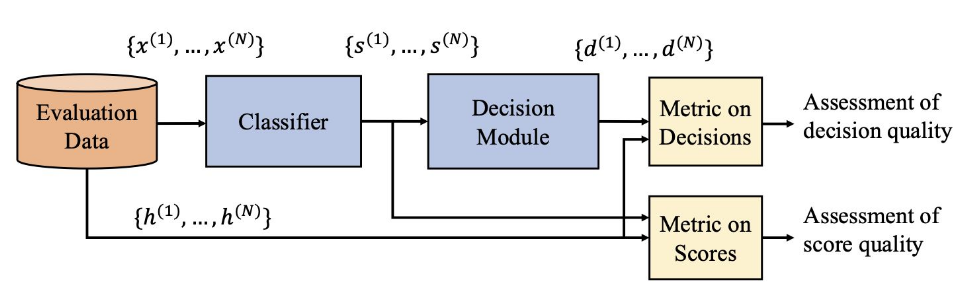

Cálculo de Balanced Accuracy ([fuente](https://arxiv.org/pdf/2008.05756))

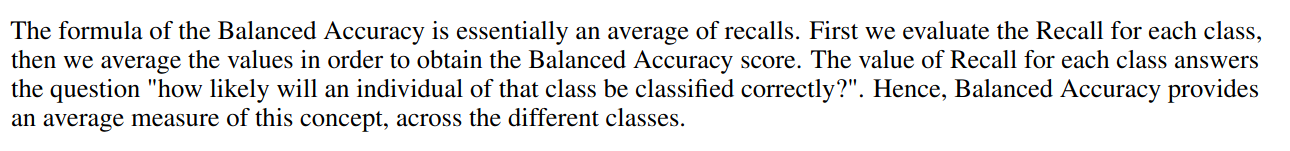

## Funciones auxiliares

### Imports

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score, precision_recall_curve, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, accuracy_score, log_loss, balanced_accuracy_score


### Configuración de almacenamiento de resultados

In [2]:
model_name = "Random Forest" # <---------- MODIFICAR PARA QUE SE CORRESPONDA COM MODELO QUE SE ESTÁ EVALUANDO!
results_dir = "plots/evaluation/"

### Matriz de Confusión

In [20]:
def generate_confusion_matrix(y_true, y_pred, classes: list[str], plot_title: str, store_path: str):
  """
  Calcula matriz de confusión para y_true e y_pred, la grafica usando como labels las clases de "classses" y como título a "plot_title".
  El gráfico se almacena en results_dir (variable global).
  """
  
  n_classes = len(classes)
  labels = np.arange(n_classes)
  
  cm = confusion_matrix(y_true, y_pred, labels=labels)
  cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

  fig, ax = plt.subplots()
  cm_display.plot(cmap="Reds", values_format="d", ax=ax)

  plt.title(plot_title)
  plt.savefig(store_path)
  plt.show()

  return cm


### Métricas - Decisiones

In [4]:
def generate_decision_metrics(confusion_matrix, classes: list[str], store_path: str):
  """
  Dada una matriz de confusión, calcula métricas de decisión y las almacena en un txt. 
  Imprime en pantalla lo almacenado.
  """
  n_predictions = np.sum(confusion_matrix)
  n_classes = len(classes)

  # Métricas x clase a calcular
  recall = np.zeros(n_classes)
  precision = np.zeros(n_classes)
  fpr = np.zeros(n_classes)
  F1 = np.zeros(n_classes)
  TP_total = 0

  for i in range(n_classes): 
    # Extrayendo TP, FN, FP y TN de la clase
    TP = confusion_matrix[i, i]
    FN = sum(confusion_matrix[i, :]) - TP
    FP = sum(confusion_matrix[:, i]) - TP
    TN = n_predictions - (TP + FN + FP)

    # Calcular métricas de la clase
    recall[i] = TP / (TP + FP)
    precision[i] = TP / (TP + FN)
    fpr[i] = FP / (FP + TN)
    F1[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i])
    TP_total += TP

  # F1 macro - promedio de los F1 x clase
  F1_macro = F1.mean()

  # Accuracy global
  accuracy = TP_total / n_predictions

  # Balanced accuracy
  balanced_accuracy = recall.mean()

  # Store metrics
  with open(store_path, "w") as file:
    for i, class_name in enumerate(classes):  file.write(f"Recall {class_name}: {recall[i]}\n")
    file.write("\n")
    for i, class_name in enumerate(classes): file.write(f"Precision {class_name}: {precision[i]}\n")
    file.write("\n")
    for i, class_name in enumerate(classes): file.write(f"FPR {class_name}: {fpr[i]}\n")
    file.write("\n")
    for i, class_name in enumerate(classes): file.write(f"F1 {class_name}: {F1[i]}\n")
    file.write("\n")
    file.write(f"F1 Macro: {F1_macro}\n")
    file.write(f"Accuracy: {accuracy}\n")
    file.write(f"Balanced Accuracy: {balanced_accuracy}\n")

  # Print metrics
  with open(store_path, "r") as file:
    print(file.read())

### Métricas - Scores

In [5]:
def generate_scores_metrics(y_true, y_proba, classes: list[str], store_path: str):
  """
  Calcula métricas de score para y_true e y_proba, independientemente de la cantidad de clases. 
  Almacena los resultados en un txt y los imprime en pantalla.
  """

  n_classes = len(classes)

  # Métricas por clase a calcular
  auc_roc_score_ovr = np.zeros(n_classes)
  average_precision_score_ovr = np.zeros(n_classes)
  for i in range(n_classes): 
    # Métricas One-vs-Rest. Se toma una clase como positiva y al resto como negativas.
    y_true_ovr = y_true == i
    y_proba_ovr = y_proba[f"y_proba_{i}"]

    auc_roc_score_ovr[i] = roc_auc_score(y_true_ovr, y_proba_ovr)
    average_precision_score_ovr[i] = average_precision_score(y_true_ovr, y_proba_ovr)

  # Métricas OvR macro, revisar si esto sirve
  auc_roc_score_ovr_macro = auc_roc_score_ovr.mean()
  average_precision_score_ovr_macro = average_precision_score_ovr.mean()

  # Cross Entropy/Log Loss
  cross_entropy = log_loss(y_true, y_proba)

  # Store metrics
  with open(store_path, "w") as file:
    for i, class_name in enumerate(classes):  file.write(f"AUC ROC OvR {class_name}: {auc_roc_score_ovr[i]}\n")
    file.write("\n")
    for i, class_name in enumerate(classes): file.write(f"Average Precision OvR {class_name}: {average_precision_score_ovr[i]}\n")
    file.write("\n")
    file.write(f"Cross Entropy: {cross_entropy}\n")
    file.write(f"AUC ROC OvR Macro: {auc_roc_score_ovr_macro}\n")
    file.write(f"Average Precision Macro: {average_precision_score_ovr_macro}\n")

  # Print metrics
  with open(store_path, "r") as file:
    print(file.read())

## Capitalización 

### Input

In [6]:
df_test_cap = pd.read_csv('../data/processed/test_cap_rf.csv')

y_test_true_cap = df_test_cap["y_cap"]
y_test_pred_cap = df_test_cap["y_pred"]
y_test_proba_cap = df_test_cap[["y_proba_0", "y_proba_1", "y_proba_2", "y_proba_3"]] 

classes_cap = ['0 hola', '1 Hola', '2 iPhone', '3 UBA']

### Matriz de confusión

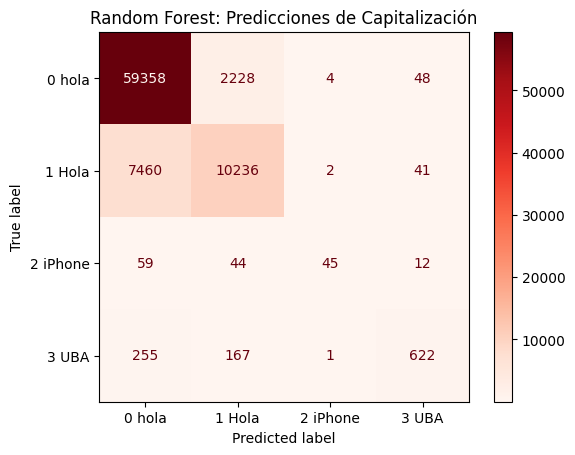

In [21]:
cm_cap = generate_confusion_matrix(
  y_test_true_cap, y_test_pred_cap, classes_cap, f"{model_name}: Predicciones de Capitalización",
  f"{results_dir}{model_name}_cap_confusion_matrix.png"  
)

### Métricas - Decisiones

In [8]:
generate_decision_metrics(cm_cap, classes_cap, f"{results_dir}{model_name}_cap_decision_metrics.txt")

Recall 0 hola: 0.8841982958946553
Recall 1 Hola: 0.8075739644970414
Recall 2 iPhone: 0.8653846153846154
Recall 3 UBA: 0.8603042876901799

Precision 0 hola: 0.9630098315973912
Precision 1 Hola: 0.5770336546592254
Precision 2 iPhone: 0.28125
Precision 3 UBA: 0.5952153110047846

FPR 0 hola: 0.41036739864864863
FPR 1 Hola: 0.0388110052034435
FPR 2 iPhone: 8.704085946631518e-05
FPR 3 UBA: 0.001269849252549128

F1 0 hola: 0.9219228081074784
F1 1 Hola: 0.6731110672716513
F1 2 iPhone: 0.4245283018867924
F1 3 UBA: 0.7036199095022624

F1 Macro: 0.680795521692046
Accuracy: 0.8719192871857239
Balanced Accuracy: 0.8543652908666229



### Métricas - Scores

In [9]:
generate_scores_metrics(y_test_true_cap, y_test_proba_cap, classes_cap, f"{results_dir}{model_name}_cap_scores_metrics.txt")

AUC ROC OvR 0 hola: 0.9137030903189766
AUC ROC OvR 1 Hola: 0.9108744348172646
AUC ROC OvR 2 iPhone: 0.8527876000969884
AUC ROC OvR 3 UBA: 0.967953303668426

Average Precision OvR 0 hola: 0.9676249106231752
Average Precision OvR 1 Hola: 0.7888038025072766
Average Precision OvR 2 iPhone: 0.4719744472460679
Average Precision OvR 3 UBA: 0.7629919357506929

Cross Entropy: 0.37452053845798666
AUC ROC OvR Macro: 0.9113296072254139
Average Precision Macro: 0.7478487740318032



## Puntuación inicial 

### Input

In [10]:
df_test_ini = pd.read_csv('../data/processed/test_ini_rf.csv')

y_test_true_ini = df_test_ini["y_punt_ini"]
y_test_pred_ini = df_test_ini["y_pred"]
y_test_proba_ini = df_test_ini[["y_proba_0", "y_proba_1"]]

classes_ini = ['Sin puntuación', '¿']

### Matriz de confusión

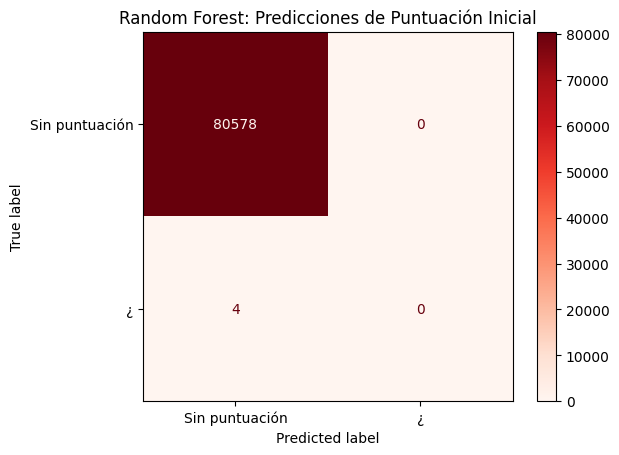

In [22]:
cm_ini = generate_confusion_matrix(
  y_test_true_ini, y_test_pred_ini, classes_ini, f"{model_name}: Predicciones de Puntuación Inicial", 
  f"{results_dir}{model_name}_ini_confusion_matrix.png"
)

### Métricas - Decisiones

In [12]:
generate_decision_metrics(cm_ini, classes_ini, f"{results_dir}{model_name}_ini_decision_metrics.txt")

Recall Sin puntuación: 0.9999503611228314
Recall ¿: nan

Precision Sin puntuación: 1.0
Precision ¿: 0.0

FPR Sin puntuación: 1.0
FPR ¿: 0.0

F1 Sin puntuación: 0.999975179945396
F1 ¿: nan

F1 Macro: nan
Accuracy: 0.9999503611228314
Balanced Accuracy: nan



/tmp/ipykernel_186430/3541484320.py:24: RuntimeWarning: invalid value encountered in scalar divide
  recall[i] = TP / (TP + FP)


### Métricas - Scores

In [13]:
generate_scores_metrics(y_test_true_ini, y_test_proba_ini, classes_ini, f"{results_dir}{model_name}_ini_scores_metrics.txt")

AUC ROC OvR Sin puntuación: 0.7493794832336369
AUC ROC OvR ¿: 0.749379483233637

Average Precision OvR Sin puntuación: 0.9999751196999134
Average Precision OvR ¿: 0.1218196912334561

Cross Entropy: 0.0009961732775995622
AUC ROC OvR Macro: 0.7493794832336369
Average Precision Macro: 0.5608974054666848



## Puntuación final

### Input

In [14]:
df_test_fin = pd.read_csv('../data/processed/test_fin_rf.csv')

y_test_true_fin = df_test_fin["y_punt_fin"]
y_test_pred_fin = df_test_fin["y_pred"]
y_test_proba_fin = df_test_fin[["y_proba_0", "y_proba_1", "y_proba_2", "y_proba_3"]]

classes_fin = ["Sin puntuación", ',', '.', '?']

### Matriz de confusión

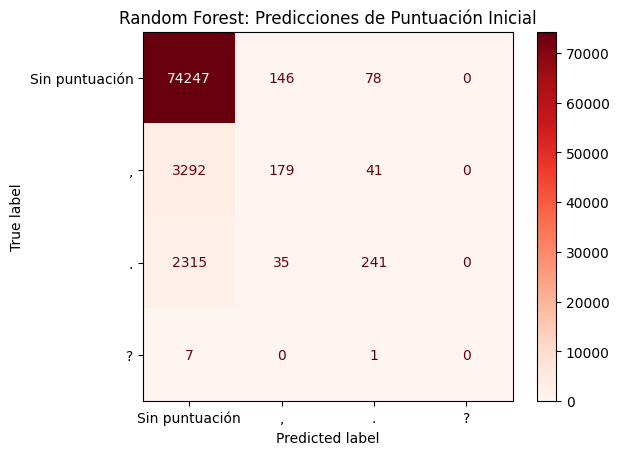

In [23]:
cm_fin = generate_confusion_matrix(
  y_test_true_fin, y_test_pred_fin, classes_fin, f"{model_name}: Predicciones de Puntuación Inicial", 
  f"{results_dir}{model_name}_fin_confusion_matrix.png"
)

### Métricas - Decisiones

In [16]:
generate_decision_metrics(cm_fin, classes_fin, f"{results_dir}{model_name}_fin_decision_metrics.txt")

Recall Sin puntuación: 0.9297028587170209
Recall ,: 0.49722222222222223
Recall .: 0.667590027700831
Recall ?: nan

Precision Sin puntuación: 0.9969921177371057
Precision ,: 0.05096810933940774
Precision .: 0.09301428020069472
Precision ?: 0.0

FPR Sin puntuación: 0.9186712485681557
FPR ,: 0.002348514337615155
FPR .: 0.0015386390737392776
FPR ?: 0.0

F1 Sin puntuación: 0.9621724593732991
F1 ,: 0.09245867768595041
F1 .: 0.1632791327913279
F1 ?: nan

F1 Macro: nan
Accuracy: 0.926596510386935
Balanced Accuracy: nan



/tmp/ipykernel_186430/3541484320.py:24: RuntimeWarning: invalid value encountered in scalar divide
  recall[i] = TP / (TP + FP)


In [17]:
generate_scores_metrics(y_test_true_fin, y_test_proba_fin, classes_fin, f"{results_dir}{model_name}_fin_scores_metrics.txt")

AUC ROC OvR Sin puntuación: 0.8633526801128054
AUC ROC OvR ,: 0.8349955244367085
AUC ROC OvR .: 0.8429595096082324
AUC ROC OvR ?: 0.684422859731427

Average Precision OvR Sin puntuación: 0.986201672242386
Average Precision OvR ,: 0.21020916948042662
Average Precision OvR .: 0.24869731354170932
Average Precision OvR ?: 0.01710481797264222

Cross Entropy: 0.3153682504310091
AUC ROC OvR Macro: 0.8064326434722934
Average Precision Macro: 0.36555324330929106



## Funciones tp1


In [18]:
# def graficar_roc_curve(y_true, y_proba, title='Curva ROC', save_path=None, threshold_mark=None):
#     score = roc_auc_score(y_true, y_proba)
#     fpr, tpr, thresholds = roc_curve(y_true, y_proba)

#     fig, ax = plt.subplots()
#     ax.plot(fpr, tpr, label=f'ROC curve (AUC = {score:.2f})')
#     ax.plot([0, 1], [0, 1], 'k--', label='Random')

#     if threshold_mark is not None:
#         idx = (np.abs(thresholds - threshold_mark)).argmin()
#         ax.scatter(fpr[idx], tpr[idx], color="red", s=80, label=f'Threshold={threshold_mark:.2f}')

#     ax.set_xlabel('FPR')
#     ax.set_ylabel('TPR')
#     ax.set_title(title)
#     ax.legend()

#     if save_path:
#         plt.savefig(save_path, dpi=300, bbox_inches="tight")

#     plt.show()


# def graficar_precision_recall_curve(y_train, y_proba, title='Precision-Recall Curve'):
#     score = average_precision_score(y_train, y_proba)
#     precision, recall, thresholds = precision_recall_curve(y_train, y_proba)
#     plt.plot(recall, precision, label=f'AUPRC curve (AUC = {score:.2f})')
#     plt.xlabel('Recall')
#     plt.ylabel('Precision')
#     plt.title(title)
#     fig, ax = plt.subplots()

#     ax.set_title(title)
#     plt.legend()

# def mostrar_matriz_confusion(y_train, y_pred, title='Matriz de confusión', save_path=None):
#         labels = ["tiene hiperplasia", "no tiene hiperplasia"]
#         cm = confusion_matrix(y_train, y_pred, labels=[1, 0])
#         disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
#         fig, ax = plt.subplots()
#         disp.plot(cmap="Blues", values_format="d", ax=ax)
#         plt.title(title)
#         if save_path:
#             plt.savefig(save_path, dpi=300, bbox_inches="tight")
#         plt.show()

#         # Extraer TP, FN, FP, TN (según orden de labels=[1,0])
#         TP, FN, FP, TN = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]

#         # Calcular TPR y FPR
#         tpr = TP / (TP + FN) if (TP + FN) > 0 else 0
#         fpr = FP / (FP + TN) if (FP + TN) > 0 else 0

#         print(f"TPR (Sensibilidad) = {tpr:.3f}, FPR = {fpr:.3f}")
#         return tpr, fpr


# def graficar_metricas_umbral(y_true, y_proba, step=0.05, save_path=None, title='Métricas en función del umbral'):
#     """
#     Grafica Recall (TPR), Accuracy y FPR en función del threshold.
#     """

#     thresholds = np.arange(0.0, 1.01, step)
#     recalls, accuracies, fprs = [], [], []

#     for t in thresholds:
#         y_pred = (y_proba >= t).astype(int)
#         recalls.append(recall_score(y_true, y_pred))             # TPR
#         accuracies.append(accuracy_score(y_true, y_pred))        # Accuracy
#         #fprs.append(precision_score(y_true, y_pred, zero_division=1))             # Precision
#         spec = recall_score(y_true, y_pred, pos_label=0)         # Specificity (TNR)
#         fprs.append(1 - spec)                                    # FPR = 1 - TNR

#     plt.figure(figsize=(10,6))
#     plt.plot(thresholds, recalls, label="Recall (TPR)", color="skyblue")
#     plt.plot(thresholds, accuracies, label="Accuracy", color="magenta")
#     plt.plot(thresholds, fprs, label="FPR", color="red")

#     plt.xlabel("Decision Boundary Threshold")
#     plt.ylabel("Score")
#     plt.title(title)
#     plt.legend()
#     plt.grid(alpha=0.3)
#     plt.ylim(0,1.05)

#     if save_path:
#         plt.savefig(save_path, dpi=300, bbox_inches="tight")

#     plt.show()


# def evaluar_resultados(y_proba, y_pred, nombre, save_prefix="/content/", plot_metricas_umbral=False):
#     """
#     Evalúa un modelo de clasificación con CV, calcula AUROC,
#     genera curva ROC, matriz de confusión y opcionalmente
#     métricas en función del umbral.
#     """

#     # AUROC
#     score_roc = roc_auc_score(y_pred, y_proba)
#     print(f"AUROC {nombre}: {score_roc:.4f}")

#     # Graficar ROC
#     graficar_roc_curve(
#         y_pred,
#         y_proba,
#         title=f"Curva ROC - {nombre}",
#         save_path=f"{save_prefix}roc_curve_{nombre}.png",
#         threshold_mark=0.5
#     )
#     #Graficar PRC
#     score_precision = average_precision_score(y_pred, y_proba)
#     print(f"Average precision {nombre}: {score_precision:.4f}")
#     graficar_precision_recall_curve(y_pred, y_proba, title=f"Curva ROC - {nombre}")

#     # Graficar matriz de confusión (y obtener TPR/FPR @0.5)
#     tpr, fpr = mostrar_matriz_confusion(
#         y_pred,
#         y_pred,
#         f"Matriz de confusión - {nombre}",
#         save_path=f"{save_prefix}conf_matrix_{nombre}.png"
#     )

#     # Graficar métricas por threshold si se pide
#     if plot_metricas_umbral:
#         graficar_metricas_umbral(
#             y_pred,
#             y_proba,
#             step=0.05,
#             title=f"Métricas en función del umbral - {nombre}",
#             save_path=f"{save_prefix}metricas_umbral_{nombre}.png"
#         )

#     return score_roc, fpr, tpr


## Dummy Classifier

In [19]:
# from sklearn.dummy import DummyClassifier
# dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)


# y_proba_train_dummy = dummy_majority.predict_proba(X_train)[:,1]
# auc_train_dummy = roc_auc_score(y_train, y_proba_train_dummy)
# y_proba_test_dummy = dummy_majority.predict_proba(X_test)[:,1]
# print(f"AUC en datos de desarrollo: {auc_train_dummy:.8f}")
# auc_test_dummy = roc_auc_score(y_test, y_proba_test_dummy)
# print(f"AUC en datos de control: {auc_test_dummy:.4f}")
# score_precision_test_dummy = average_precision_score(y_test, y_proba_test_dummy)
# print(f"Avarage precision en datos de control: {score_precision_test_dummy:.4f}")

# graficar_precision_recall_curve(y_test, y_proba_test_dummy, title="Curva PR - Dummy - Datos de control")
# graficar_roc_curve(y_test, y_proba_test_dummy, title= "Curva ROC - Dummy - datos de control")